In [1]:
import re
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import emoji

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression


In [2]:
# Dataset columns don't have names, so I labeled them

Column_Names = ["sentiment", "ids", "date", "flag", "user", "text"]

dataset = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                      encoding = "ISO-8859-1", names = Column_Names)
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<Axes: title={'center': "Distribtion of tweet's sentiment"}, xlabel='sentiment'>

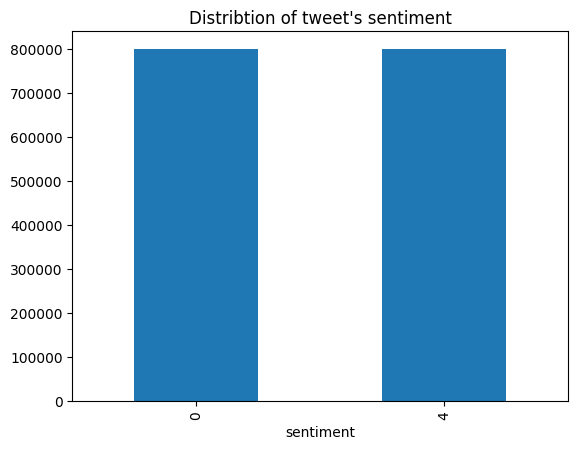

In [3]:
#Removing the unnecessary columns.
dataset = dataset[["sentiment", "text"]] 
dataset["sentiment"].value_counts().plot(kind = 'bar', title = "Distribtion of tweet's sentiment")


* The tweets have been annotated (0 = negative, 4 = positive)
* No neutral reviews
* This dataset isn't skewed (num of negtive tweets equal the positive one)


In [3]:
# Replacing 4 (represent postive review) to 1 for ease understanding
dataset["sentiment"] = dataset["sentiment"].replace(4,1)

# Store data in list for preprocessing
text,sentiment = list(dataset["text"]),list(dataset["sentiment"])

# **Preprocessing Text data**

In [4]:
# Define stopwords (excluding negations cuz it affects the context)
stop_words = set(stopwords.words("english")) - {"not", "none", "never"}

stem = True  
stemmer = PorterStemmer()

def preprocess_text(text):
    if not isinstance(text, str):  
        return ""

    # Lowercasing and remove unwanted characters in one regex pass
    text = re.sub(r'\d+|@[^\s]+|https?://\S+|www\.\S+|[^\w\s]', '', text.lower()).strip()
    
    # Removing Consecutive letters
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    # Convert emojis to text
    text = emoji.demojize(text)

    # Remove stopwords + Stemming
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    
    return " ".join(tokens)

t = time.time()
dataset["preprocessed_text"] = dataset["text"].astype(str).apply(preprocess_text)
print(f'Time Taken for preprocessing: {round(time.time()-t)} seconds') 

Time Taken for preprocessing: 297 seconds


In [6]:
dataset.head(10)

,sentiment,text,preprocessed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,0,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound
3,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",not behav im mad cant see
5,0,@Kwesidei not the whole crew,not whole crew
6,0,Need a hug,need hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time see ye rain bit bit lol im fine ...
8,0,@Tatiana_K nope they didn't have it,nope didnt
9,0,@twittera que me muera ?,que muera


In [5]:
dataset = dataset.drop(columns=['text']) 

**Handling slang and chatwords for better modeling preformance**

In [8]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "im" : "i am",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [9]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [10]:
def get_abbrev(text):    
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() in abbreviations.keys()]
    text = ' '.join(tokens)
    return text
    

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens=[convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text
    
dataset['abbreviations_in_text'] = dataset['preprocessed_text'].apply(lambda x: get_abbrev(x))


In [12]:
not_in_data = [] ; in_data = []
for i in abbreviations.keys():
    if dataset[dataset['abbreviations_in_text'].str.contains(i, na=False, case=False)].empty:
        not_in_data.append(i)
    else :
        in_data.append(i)
print("Abbreviations in data : {}\n{}\n\nAbbreviations not in data : {}\n{}\n".format(len(in_data), in_data, len(not_in_data), not_in_data))

Abbreviations in data : 151
['$', 'acct', 'afaic', 'afaict', 'afaik', 'afair', 'afk', 'app', 'approx', 'asap', 'asl', 'atk', 'b+b', 'b.c', 'bae', 'bak', 'bbc', 'bbl', 'bfn', 'blvd', 'bout', 'brb', 'brt', 'btw', 'bwl', 'cet', 'cf', 'cia', 'csl', 'cu', 'cv', 'cya', 'cyt', 'dae', 'diy', 'dm', 'dwh', 'eet', 'eg', 'encl', 'etc', 'faq', 'fb', 'fc', 'fig', 'ft.', 'ft', 'ftl', 'ftw', 'fwiw', 'fyi', 'gal', 'gcse', 'gg', 'gl', 'gmt', 'gmta', 'gn', 'goat', 'goi', 'gratz', 'gyal', 'hp', 'hr', 'hrh', 'ht', 'im', 'ic', 'icq', 'idc', 'idgaf', 'idk', 'ie', 'IG', 'iirc', 'ilu', 'imho', 'imo', 'imu', 'iow', 'irl', 'jic', 'jk', 'jsyk', 'lb', 'ldr', 'lmao', 'lmfao', 'lol', 'ltd', 'mf', 'mofo', 'mph', 'mr', 'mrw', 'ms', 'mte', 'nagi', 'nbc', 'nbd', 'ngl', 'nrn', 'nsfw', 'nth', 'nvr', 'nyc', 'oc', 'og', 'ohp', 'oic', 'omg', 'omw', 'p.a', 'p.m', 'pm', 'poc', 'pov', 'pp', 'ppl', 'ps', 'pt', 'pto', 'ratchet', 'rofl', 'roflol', 'rotflmao', 'rt', 'sfw', 'smh', 'sq', 'tbh', 'tbs', 'tbsp', 'tfw', 'tho', 'thx', 'ti

In [11]:
dataset['converted_text'] = dataset['preprocessed_text'].apply(lambda x: convert_abbrev_in_text(x))

In [15]:
dataset.head(10)

,sentiment,preprocessed_text,abbreviations_in_text,converted_text
0,0,aww that bummer shoulda got david carr third day,,aww that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...,,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound,,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire,,whole bodi feel itchi like fire
4,0,not behav im mad cant see,im,not behav i am mad cant see
5,0,not whole crew,,not whole crew
6,0,need hug,,need hug
7,0,hey long time see ye rain bit bit lol im fine ...,lol im,hey long time see ye rain bit bit laughing out...
8,0,nope didnt,,nope didnt
9,0,que muera,,que muera


In [11]:
dataset = dataset.drop(columns = ['abbreviations_in_text', 'preprocessed_text'])
dataset = dataset.rename(columns = {'converted_text':'preprocessed_text'})

In [30]:
dataset.head()

,sentiment,preprocessed_text
0,0,aww that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,not behav i am mad cant see


# Analysing data

Word Cloud of negative and positive words

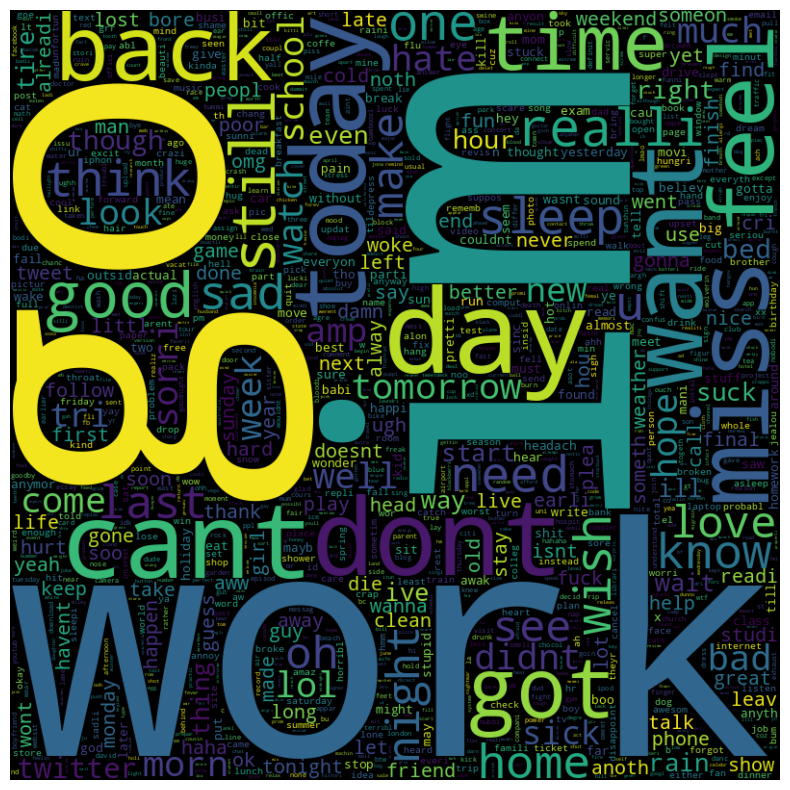

In [6]:
negative_reviews = dataset[dataset["sentiment"] == 0]["preprocessed_text"][:80000] 
plt.figure(figsize=(10, 10))
wc = WordCloud(max_words=10000, height=800, width=800, collocations=False).generate(" ".join(negative_reviews))

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


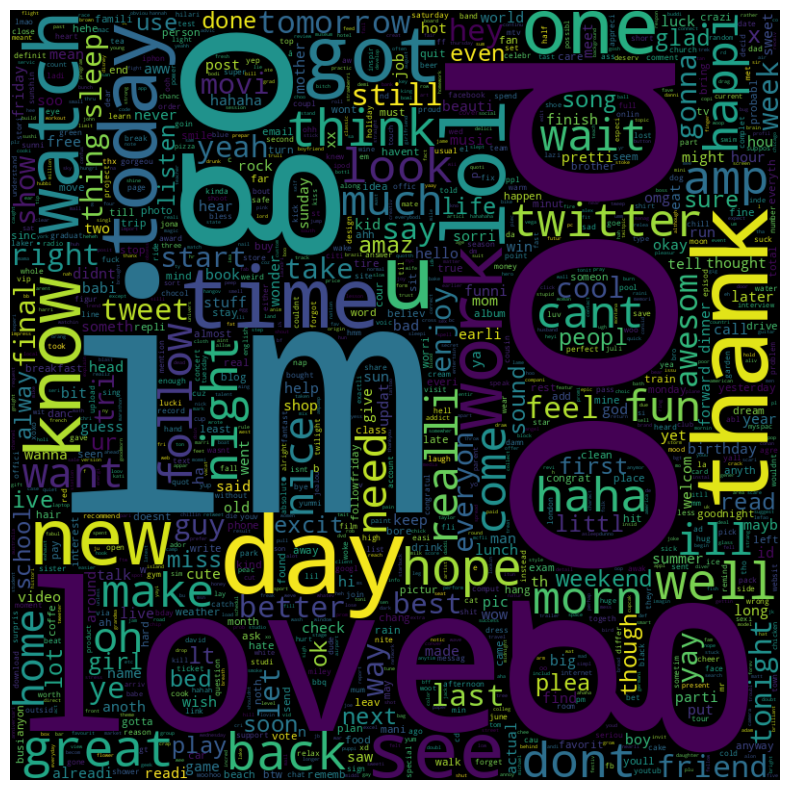

In [7]:
positive_reviews = dataset[dataset["sentiment"] == 1]["preprocessed_text"][80000:] 

plt.figure(figsize=(10, 10))
wc = WordCloud(max_words=10000, height=800, width=800, collocations=False).generate(" ".join(positive_reviews))

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Train and Test Split

In [12]:
train, test = train_test_split(dataset, test_size = 0.20,random_state = 0)
print("TRAIN size:", len(train))
print("TEST size:", len(test))

TRAIN size: 1280000
TEST size: 320000


# Tokenization

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000) #to get the most frequent words
tokenizer.fit_on_texts(train.preprocessed_text)
word_index = tokenizer.word_index # contains the index for each word
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 298516


**Padding: to ensure consistent input size for modelling performance**

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 40

x_train = pad_sequences(tokenizer.texts_to_sequences(train.preprocessed_text),maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.preprocessed_text),maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 40)
Testing X Shape: (320000, 40)


In [38]:
labels = train.sentiment.unique().tolist()
labels

[1, 0]

# **TF-IDF Vectoriser**

In [52]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(train['preprocessed_text'].astype(str))

print('No. of feature words:', len(vectorizer.get_feature_names_out()))


No. of feature words: 500000


In [55]:
X_train = vectorizer.transform(train['preprocessed_text'])
X_test  = vectorizer.transform(test['preprocessed_text'])
print(f'Data Transformed.')

Data Transformed.


In [56]:
y_train = train['sentiment']
y_test = test['sentiment']

# **ML Models**

Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions. We're choosing Accuracy as our evaluation metric

# **Model Evaluatation Function**

In [57]:
def evaluate_model(model):
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    
    # Calculates what % of the total each cell represents
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


# **Logistic Regression**

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159815
           1       0.80      0.82      0.81    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



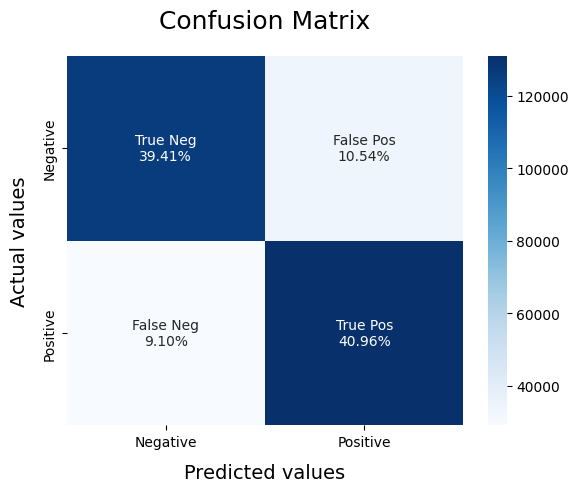

In [58]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000)
LRmodel.fit(X_train,y_train)
evaluate_model(LRmodel)

# **LinearSVC**

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159815
           1       0.78      0.80      0.79    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



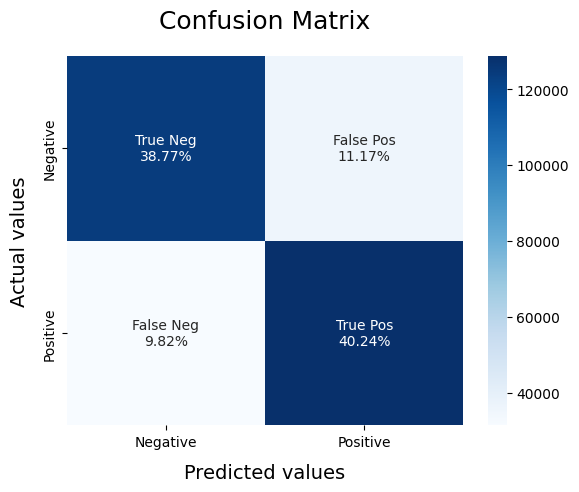

In [61]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train,y_train)
evaluate_model(SVCmodel)

# **Bernoulli Naive Bayes**

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159815
           1       0.77      0.81      0.79    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.78    320000
weighted avg       0.79      0.79      0.78    320000



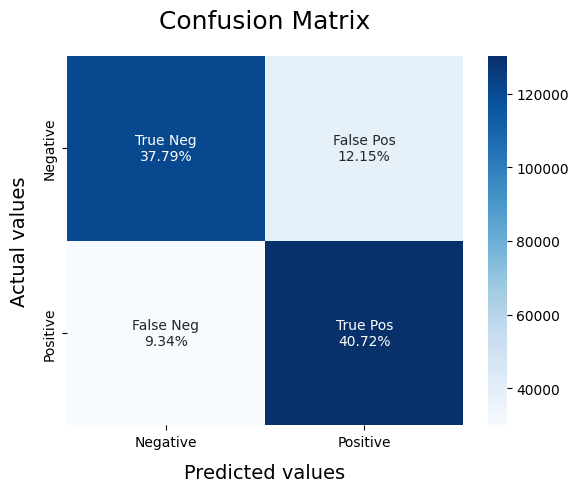

In [71]:
BerNB = BernoulliNB(alpha = 2)
BerNB.fit(X_train,y_train)
evaluate_model(BerNB)

# **XGBoost**

              precision    recall  f1-score   support

           0       0.79      0.69      0.74    159815
           1       0.73      0.82      0.77    160185

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.75    320000
weighted avg       0.76      0.76      0.75    320000



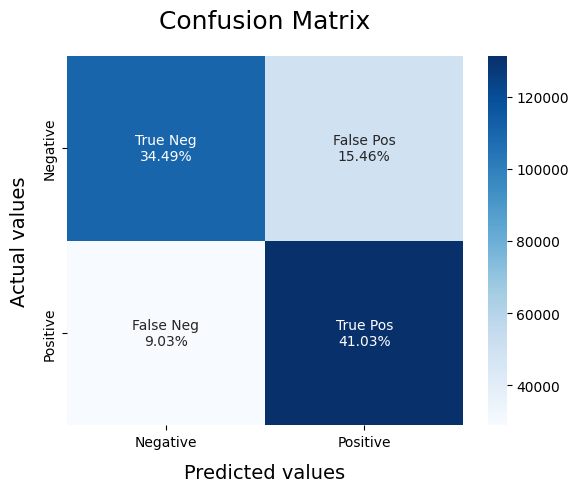

In [74]:
from xgboost import XGBClassifier

XGBoostModel = XGBClassifier()
XGBoostModel.fit(X_train,y_train)
evaluate_model(XGBoostModel)

By comparing the accuracies of all the ML models, it turns out that **Logistic regression** model has the highst accuracy of **80%**, but **BernoulliNB** Model was the **fastest** model to train the data and make prediction

# **Save Models using Pickle**

In [77]:
vec = pickle.dumps(vectorizer)

LogReg = pickle.dumps(LRmodel)

BNB = pickle.dumps(BerNB)


# Word Ebedding using Word2Vec

In [17]:
import shutil

src = "/kaggle/input/smart-open-7-1-0-tar-gz/smart_open-7.1.0/smart_open"
dest = "/usr/local/lib/python3.10/dist-packages/smart_open"

shutil.copytree(src, dest, dirs_exist_ok=True)
print("smart_open installed manually!")


smart_open installed manually!


In [18]:
import smart_open
print("smart_open imported successfully!")

smart_open imported successfully!


In [ ]:
%%time

documents = [_text.split() for _text in train.preprocessed_text] 

In [20]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 1024

In [21]:
from gensim.models import KeyedVectors

# Path to uploaded pretrained Word2Vec model
word2vec_path = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"

word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

print("Word2Vec Loaded Successfully!")


Word2Vec Loaded Successfully!


In [17]:
import gensim
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [27]:
w2v_model.build_vocab(documents)

In [32]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 0


In [31]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 35min 21s, sys: 6.57 s, total: 35min 27s
Wall time: 9min 7s


(265041696, 307510560)

In [32]:

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(30133, 300)


# **LSTM Model** 

In [33]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], trainable=False)


In [34]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,039,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,039,900 (34.48 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,039,900 (34.48 MB)

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [48]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4,mode = "max",  patience=5)]

In [51]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 415s 369ms/step - accuracy: 0.7631 - loss: 0.4832 - val_accuracy: 0.7706 - val_loss: 0.4764 - learning_rate: 0.0010
Epoch 2/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 433s 385ms/step - accuracy: 0.7631 - loss: 0.4826 - val_accuracy: 0.7702 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 3/3
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 437s 388ms/step - accuracy: 0.7635 - loss: 0.4821 - val_accuracy: 0.7711 - val_loss: 0.4734 - learning_rate: 0.0010
CPU times: user 1h 1min 41s, sys: 9min 32s, total: 1h 11min 14s
Wall time: 21min 25s


In [52]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.7712 - loss: 0.4732

ACCURACY: 0.772362470626831
LOSS: 0.4712270498275757
CPU times: user 2min 8s, sys: 32.7 s, total: 2min 41s
Wall time: 53.3 s
